In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib qt
import sys; sys.path.insert(0, '../')
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import pearsonr
import mne
sys.path.insert(0, '../../esinet')

from esinet import Simulation
from esinet.forward import get_info, create_forward_model
from esinet.util import unpack_fwd
pp = dict(surface='white', hemi='both', verbose=0)

In [2]:
info = get_info(kind='biosemi64')
fwd = create_forward_model(info=info, sampling='ico3')

leadfield, pos = unpack_fwd(fwd)[1:3]
n_chans, n_dipoles = leadfield.shape

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    2.7s remaining:    2.7s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    2.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.3s finished


Simulating data based on sparse patches.


100%|██████████| 2/2 [00:00<00:00,  6.94it/s]


No projector specified for this dataset. Please consider the method self.add_proj.


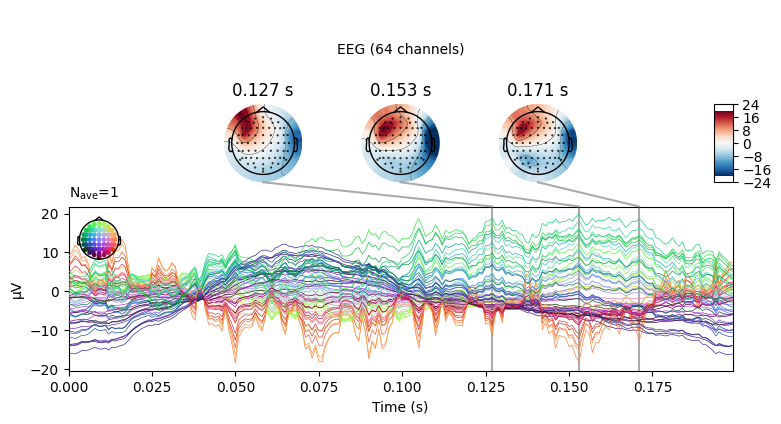

In [3]:
settings = dict(
    number_of_sources=4,
    extents=(1, 2),
    duration_of_trial=0.2,
    amplitudes=(99, 100),
    target_snr=1e99,
    beta_noise=0,
    method="standard")

sim = Simulation(fwd, info, settings).simulate(2)
stc = sim.source_data[0]
evoked = sim.eeg_data[0].average()

stc.data /= abs(stc.data).max()
brain = stc.plot(**pp)
brain.add_text(0.1, 0.9, 'Ground Truth', 'title',
               font_size=14)
evoked.plot_joint()

# Beamformer

In [ ]:

def correlated_beamformer(eeg_data, leadfield_matrix, source_covariance):
    """
    Solves the EEG inverse problem using a beamformer algorithm that can handle correlated sources.
    
    Parameters:
    - eeg_data: A 2D array of shape (num_sensors, num_samples) containing the EEG data measured by the sensors.
    - leadfield_matrix: A 2D array of shape (num_sensors, num_sources) containing the leadfield forward matrix.
    - source_covariance: A 2D array of shape (num_sources, num_sources) containing the covariance of the sources.
    
    Returns:
    - source_estimate: A 2D array of shape (num_sources, num_samples) containing the estimated sources.
    """
    # Compute the spatial filters using the leadfield matrix and the source covariance
    spatial_filters = compute_spatial_filters(leadfield_matrix, source_covariance)
    
    # Compute the source estimate using the spatial filters and the EEG data
    source_estimate = compute_source_estimate(eeg_data, spatial_filters)
    
    return source_estimate

def compute_spatial_filters(leadfield_matrix, source_covariance):
    """
    Computes the spatial filters using the leadfield matrix and the source covariance.
    
    Parameters:
    - leadfield_matrix: A 2D array of shape (num_sensors, num_sources) containing the leadfield forward matrix.
    - source_covariance: A 2D array of shape (num_sources, num_sources) containing the covariance of the sources.
    
    Returns:
    - spatial_filters: A 2D array of shape (num_sources, num_sensors) containing the spatial filters.
    """
    # Compute the spatial filters using the leadfield matrix and the source covariance
    spatial_filters = np.dot(np.linalg.inv(source_covariance), leadfield_matrix)
    
    return spatial_filters

def compute_source_estimate(eeg_data, spatial_filters):
    """
    Computes the source estimate using the EEG data and the spatial filters.
    
    Parameters:
    - eeg_data: A 2D array of shape (num_sensors, num_samples) containing the EEG data measured by the sensors.
    - spatial_filters: A 2D array of shape (num_sources, num_sensors) containing the spatial filters.
    
    Returns:
    - source_estimate: A 2D array of shape (num_sources, num_samples) containing the estimated sources.
    """
    # Compute the source estimate using the spatial filters and the EEG data
    source_estimate = np.dot(spatial_filters.T, eeg_data)
    
    return source_estimate


y = evoked.data
y -= y.mean(axis=0)
y /= np.linalg.norm(y)
C = y@y.T
C -= C.mean(axis=0)
C /= np.linalg.norm(C, axis=0)
n_chans, n_times = y.shape
n_dipoles = leadfield.shape[1]

leadfield -= leadfield.mean(axis=0)
leadfield /= np.linalg.norm(leadfield, axis=0)

x0 = np.linalg.pinv(leadfield) @ y
x0 /= np.linalg.norm(x0)
num_iterations = 10
max_num_sources = 10
x = correlated_beamformer(y, leadfield, C)

stc_ = stc.copy()
stc_.data = x/abs(x).max()
stc_.plot(**pp)

# Beamformer 2

In [ ]:
def correlated_beamformer(eeg_data, leadfield_matrix, source_covariance, lambda_):
    """
    Solves the EEG inverse problem using a beamformer algorithm that can handle correlated sources and promotes sparsity in the solutions.
    
    Parameters:
    - eeg_data: A 2D array of shape (num_sensors, num_samples) containing the EEG data measured by the sensors.
    - leadfield_matrix: A 2D array of shape (num_sensors, num_sources) containing the leadfield forward matrix.
    - source_covariance: A 2D array of shape (num_sources, num_sources) containing the covariance of the sources.
    - lambda_: The regularization parameter that controls the amount of sparsity in the solutions.

    Returns:
    - source_estimate: A 2D array of shape (num_sources, num_samples) containing the estimated sources.
    """
    # Compute the spatial filters using the leadfield matrix, source covariance, and regularization parameter
    spatial_filters = compute_spatial_filters(leadfield_matrix, source_covariance, lambda_)

    # Compute the source estimate using the spatial filters and the EEG data
    source_estimate = compute_source_estimate(eeg_data, spatial_filters)

    return source_estimate

def compute_spatial_filters(leadfield_matrix, source_covariance, lambda_):
    """
    Computes the spatial filters using the leadfield matrix, source covariance, and regularization parameter.
    Parameters:
    - leadfield_matrix: A 2D array of shape (num_sensors, num_sources) containing the leadfield forward matrix.
    - source_covariance: A 2D array of shape (num_sources, num_sources) containing the covariance of the sources.
    - lambda_: The regularization parameter that controls the amount of sparsity in the solutions.

    Returns:
    - spatial_filters: A 2D array of shape (num_sources, num_sensors) containing the spatial filters.
    """
    # Compute the regularized spatial filters using the leadfield matrix, source covariance, and regularization parameter
    spatial_filters = np.dot(np.linalg.inv(source_covariance + lambda_ * np.eye(source_covariance.shape[0])), leadfield_matrix).T

    return spatial_filters

def compute_source_estimate(eeg_data, spatial_filters):
    """
    Computes the source estimate using the EEG data and the spatial filters.
    Parameters:
    - eeg_data: A 2D array of shape (num_sensors, num_samples) containing the EEG data measured by the sensors.
    - spatial_filters: A 2D array of shape (num_sources, num_sensors) containing the spatial filters.

    Returns:
    - source_estimate: A 2D array of shape (num_sources, num_samples) containing the estimated sources.
    """
    # Compute the source estimate using the spatial filters and the EEG data
    source_estimate = np.dot(spatial_filters, eeg_data)

    return source_estimate



y = evoked.data
y -= y.mean(axis=0)
y /= np.linalg.norm(y)
C = y@y.T
C -= C.mean(axis=0)
C /= np.linalg.norm(C, axis=0)
n_chans, n_times = y.shape
n_dipoles = leadfield.shape[1]

leadfield -= leadfield.mean(axis=0)
leadfield /= np.linalg.norm(leadfield, axis=0)

x0 = np.linalg.pinv(leadfield) @ y
x0 /= np.linalg.norm(x0)
lambda_ = 1e2
x = correlated_beamformer(y, leadfield, C, lambda_)

stc_ = stc.copy()
stc_.data = x/abs(x).max()
stc_.plot(**pp)

# FISTA Beamformer

In [15]:
import numpy as np

def correlated_beamformer(eeg_data, leadfield_matrix, source_covariance, lambda_, threshold):
    """
    Solves the EEG inverse problem using a beamformer algorithm that can handle correlated sources and promotes sparsity in the solutions using thresholding.
    
    Parameters:
    - eeg_data: A 2D array of shape (num_sensors, num_samples) containing the EEG data measured by the sensors.
    - leadfield_matrix: A 2D array of shape (num_sensors, num_sources) containing the leadfield forward matrix.
    - source_covariance: A 2D array of shape (num_sources, num_sources) containing the covariance of the sources.
    - lambda_: The regularization parameter that controls the amount of sparsity in the solutions.
    - threshold: The threshold used to make the solutions more sparse.
    
    Returns:
    - source_estimate: A 2D array of shape (num_sources, num_samples) containing the estimated sources.
    """
    # Compute the spatial filters using the leadfield matrix, source covariance, and regularization parameter
    spatial_filters = compute_spatial_filters(leadfield_matrix, source_covariance, lambda_)
    
    # Threshold the spatial filters to make the solutions more sparse
    spatial_filters = threshold_spatial_filters(spatial_filters, threshold)
    
    # Compute the source estimate using the spatial filters and the EEG data
    source_estimate = compute_source_estimate(eeg_data, spatial_filters)
    
    return source_estimate

def compute_spatial_filters(leadfield_matrix, source_covariance, lambda_):
    """
    Computes the spatial filters using the leadfield matrix, source covariance, and regularization parameter.
    
    Parameters:
    - leadfield_matrix: A 2D array of shape (num_sensors, num_sources) containing the leadfield forward matrix.
    - source_covariance: A 2D array of shape (num_sources, num_sources) containing the covariance of the sources.
    - lambda_: The regularization parameter that controls the amount of sparsity in the solutions.
    Returns:
    - spatial_filters: A 2D array of shape (num_sources, num_sensors) containing the spatial filters.
    """
    # Compute the regularized spatial filters using the leadfield matrix, source covariance, and regularization parameter
    spatial_filters = np.dot(np.linalg.inv(source_covariance + lambda_ * np.eye(source_covariance.shape[0])), leadfield_matrix)

    return spatial_filters

def threshold_spatial_filters(spatial_filters, threshold):
    """
    Thresholds the spatial filters to make the solutions more sparse.
    Parameters:
    - spatial_filters: A 2D array of shape (num_sources, num_sensors) containing the spatial filters.
    - threshold: The threshold used to make the solutions more sparse.

    Returns:
    - spatial_filters: A 2D array of shape (num_sources, num_sensors) containing the thresholded spatial filters.
    """
    # Threshold the spatial filters by setting elements with absolute value less than the threshold to zero
    spatial_filters[np.abs(spatial_filters) < threshold] = 0

    return spatial_filters

def compute_source_estimate(eeg_data, spatial_filters):
    """
    Computes the source estimate using the EEG data and the spatial filters.

    Parameters:
    - eeg_data: A 2D array of shape (num_sensors, num_samples) containing the EEG data measured by the sensors.
    - spatial_filters: A 2D array of shape (num_sources, num_sensors) containing the spatial filters.

    Returns:
    - source_estimate: A 2D array of shape (num_sources, num_samples) containing the estimated sources.
    """
    # Compute the source estimate using the spatial filters and the EEG data
    source_estimate = np.dot(spatial_filters.T, eeg_data)

    return source_estimate



y = evoked.data
y -= y.mean(axis=0)
y /= np.linalg.norm(y)
C = y@y.T
C -= C.mean(axis=0)
C /= np.linalg.norm(C, axis=0)
n_chans, n_times = y.shape
n_dipoles = leadfield.shape[1]

leadfield -= leadfield.mean(axis=0)
leadfield /= np.linalg.norm(leadfield, axis=0)

x0 = np.linalg.pinv(leadfield) @ y
x0 /= np.linalg.norm(x0)
lambda_ = 1e3
threshold =0
x = correlated_beamformer(y, leadfield, C, lambda_, threshold)

stc_ = stc.copy()
stc_.data = x/abs(x).max()
stc_.plot(**pp)


Using control points [0.50722457 0.5346325  0.62398081]
Using control points [0.84352866 0.86190975 0.93936226]
